## Porosity

Once obtained oBD and mBD from SiNN, it's possible to determine the porosity as, following the work of [Robinson et al., 2022](https://doi.org/10.1038/s41598-022-11099-7):


$$
\varphi
= 1 -
\left[
\left(
\frac{SOM}{oPD} + \frac{1 - SOM}{mPD}
\right)
\div
\left(
\frac{SOM}{oBD} + \frac{1 - SOM}{mBD}
\right)
\right]
$$

where oBD and mBD are bulk density of the organic and mineral constituent of soil, while mPD and oPD are the corresponding particle density. Here we assume a constant number for oPD and mPD, adopting the one used by [Robinson et al., 2022](https://doi.org/10.1038/s41598-022-11099-7), mPD 2.7 g cm−3 and oPD 1.4 g cm−3，



In [17]:
import pandas as pd
import numpy as np
version = 'v20251209'
df = pd.read_parquet(f'./eval/all_cv.pred_with.lc_{version}.pq')
hbd = df[['row_id', 'time', 'lat', 'lon', 'id', 'nuts0', 'maxdiff', 'bd', 'clay',
       'sand', 'silt', 'cf', 'ocd', 'soc', 'SOCconc', 'CF', 'BD', 'SOCdensity',
       'ndvi', 'ndwi', 'lst_night', 'lst_day', 'precipitation', 'peat',
       'SiNN_BD', 'SiNN_SOCconc', 'SiNN_CF', 'SiNN_SOCdensity', 'pred_oBD',
       'pred_mBD', 'LC1', 'LC_group']].copy()
print(hbd.shape)

# calculate porocity
hbd["som"] = hbd["soc"] * 1.724/1000
hbd["som"] = np.minimum(hbd["som"], 1)

hbd["isom"] = 1 - hbd["som"]

mPD = 2.7
oPD = 1.4

hbd["poro"] = 1 - (
    (hbd["som"] / oPD + hbd["isom"] / mPD) /
    (hbd["som"] / hbd["pred_oBD"] + hbd["isom"] / hbd["pred_mBD"])
)

(56117, 32)


In [25]:
stats = (
    hbd
    .dropna(subset=["LC_group", "poro"])
    .groupby("LC_group")["poro"]
    .agg(["count", "mean", "std", "min", "median", "max"])
)

print(stats)


            count      mean       std       min    median       max
LC_group                                                           
artificial    177  0.609641  0.069946  0.470125  0.592804  0.902966
bareland     1513  0.568565  0.048879  0.426671  0.563735  0.872562
cropland    25150  0.561579  0.047061  0.408727  0.556370  0.892750
grassland   12779  0.615703  0.064542  0.418813  0.608243  0.937388
shrubland    1768  0.651156  0.069968  0.475980  0.642168  0.936486
wetland       154  0.775127  0.146949  0.445511  0.846390  0.942256
woodland    14428  0.682233  0.088292  0.448421  0.670274  0.951836


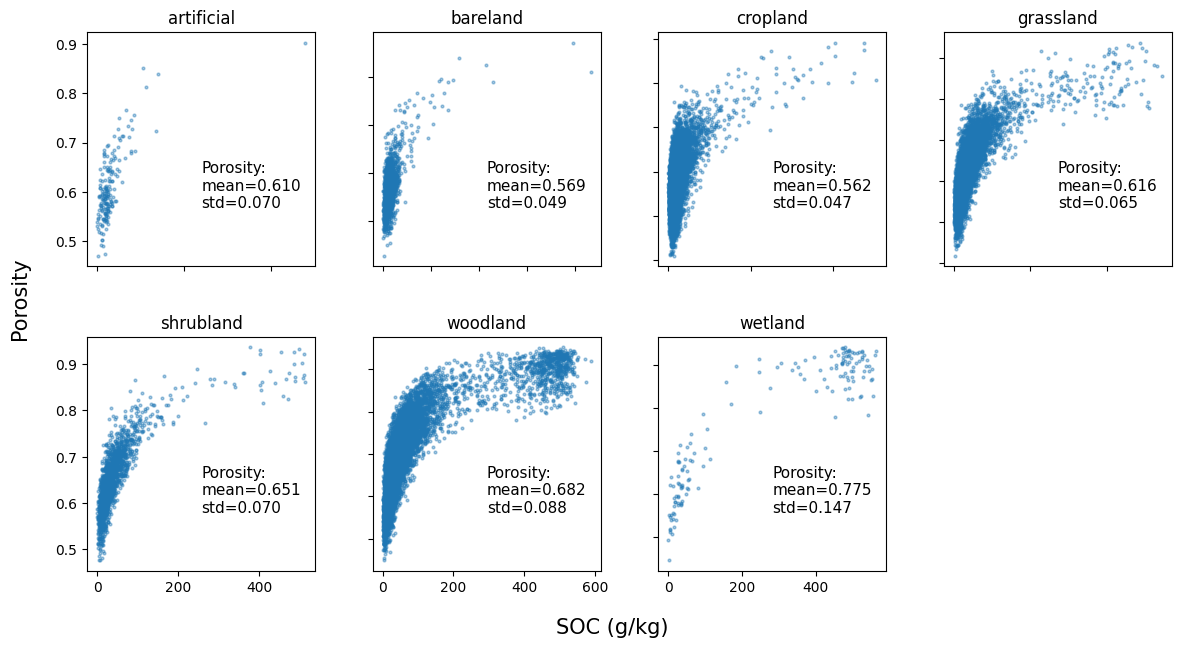

In [50]:
# 指定绘图顺序
lc_order = [
    "artificial",
    "bareland",
    "cropland",
    "grassland",
    "shrubland",
    "woodland",
    "wetland",
]

# 只保留数据中实际存在的 LC
lc_groups = [lc for lc in lc_order if lc in hbd["LC_group"].unique()]
lc_groups = lc_groups[:7]   # 4 + 3

fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.25)

axes = []

for i in range(4):
    axes.append(fig.add_subplot(gs[0, i]))

for i in range(3):
    axes.append(fig.add_subplot(gs[1, i]))

for i, (ax, lc) in enumerate(zip(axes, lc_groups)):
    mask = hbd["LC_group"] == lc
    soc = hbd.loc[mask, "soc"]
    poro = hbd.loc[mask, "poro"]

    ax.scatter(soc, poro, s=4, alpha=0.4)

    poro_std, poro_mean = poro.std(), poro.mean()
    ax.text(
        0.5, 0.45,
        f"Porosity:\nmean={poro_mean:.3f}\nstd={poro_std:.3f}",
        transform=ax.transAxes,
        va="top",
        ha="left",
        fontsize=11
    )

    ax.set_title(str(lc), fontsize=12)

    # 只显示最左边 y 轴
    if i not in [0, 4]:
        ax.tick_params(labelleft=False)

    # 只显示最底行 x 轴
    if i < 4:
        ax.tick_params(labelbottom=False)

# 统一轴标签
fig.text(0.07, 0.5, "Porosity", va="center", rotation="vertical", fontsize=15)
fig.text(0.5, 0.02, "SOC (g/kg)", ha="center", fontsize=15)
fig.savefig(f"./fig/porosity.pdf", bbox_inches="tight")

plt.show()



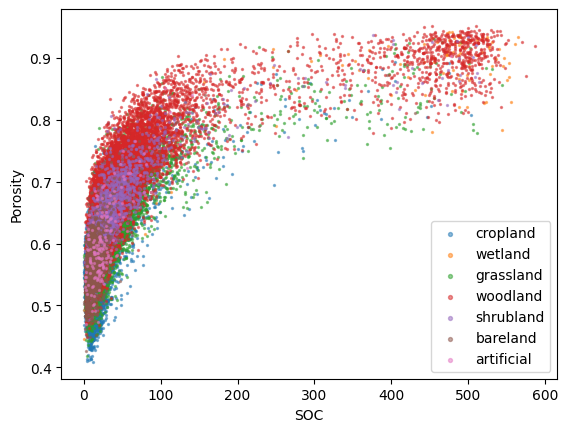

In [27]:
import matplotlib.pyplot as plt

for lc in hbd["LC_group"].dropna().unique():
    mask = hbd["LC_group"] == lc
    plt.scatter(
        hbd.loc[mask, "soc"],
        hbd.loc[mask, "poro"],
        s=2,
        alpha=0.5,
        label=lc
    )

plt.xlabel("SOC")
plt.ylabel("Porosity")
plt.legend(markerscale=2)
plt.show()


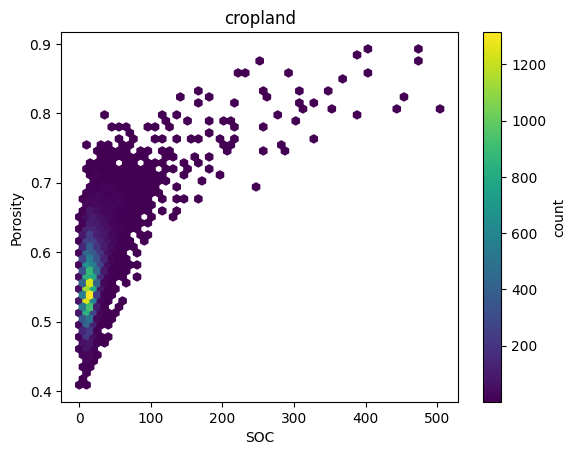

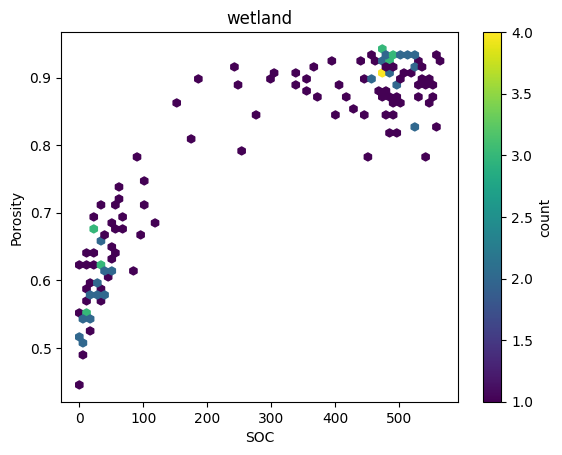

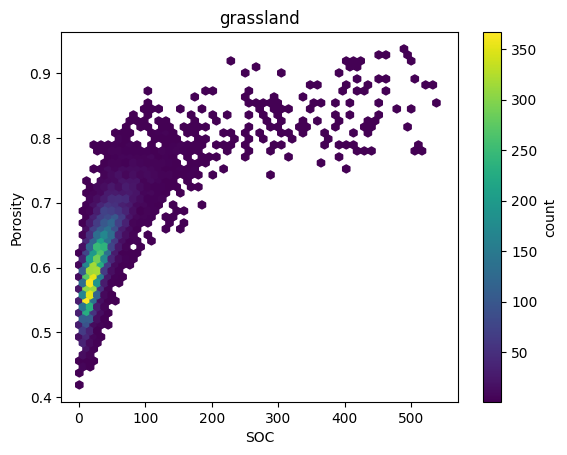

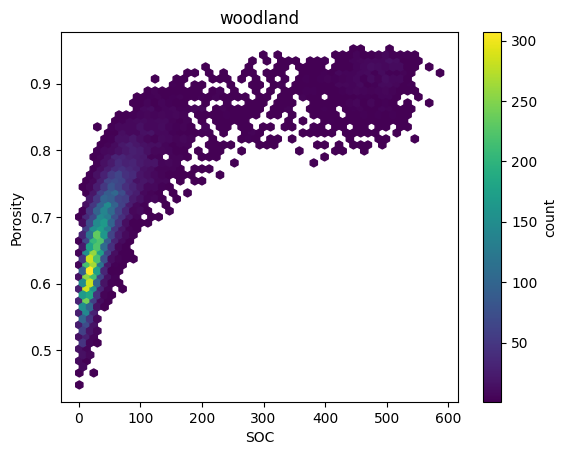

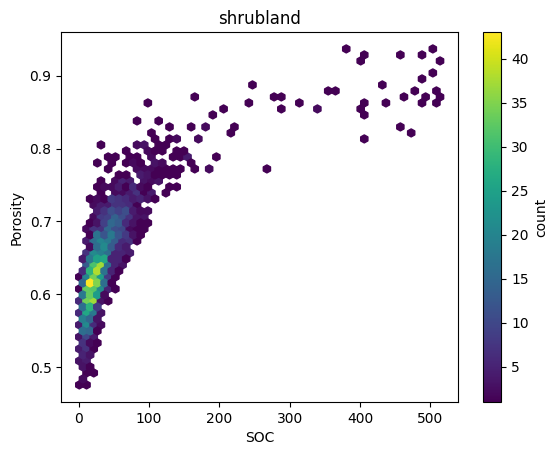

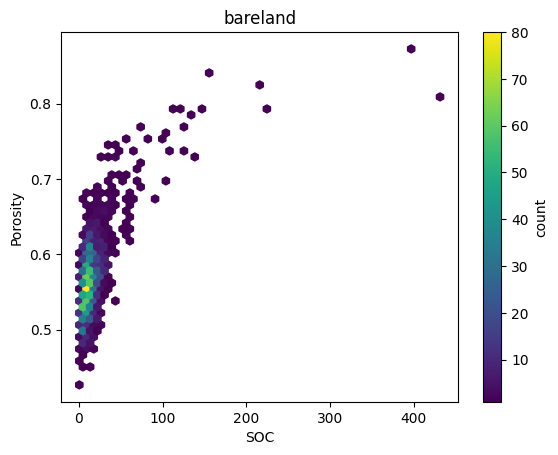

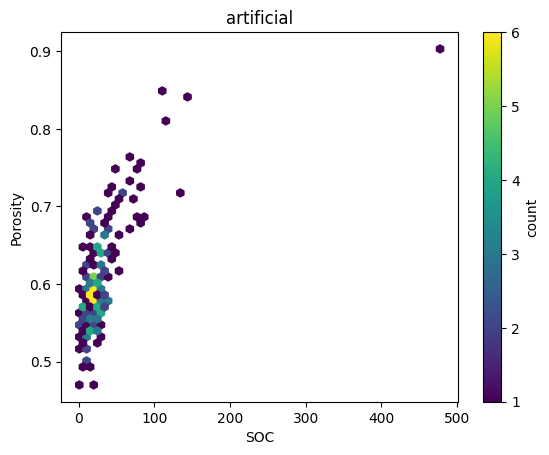

In [24]:

for lc in hbd["LC_group"].dropna().unique():
    mask = hbd["LC_group"] == lc

    plt.figure()
    plt.hexbin(
        hbd.loc[mask, "soc"],
        hbd.loc[mask, "poro"],
        gridsize=50,
        mincnt=1
    )
    plt.xlabel("SOC")
    plt.ylabel("Porosity")
    plt.title(lc)
    plt.colorbar(label="count")
    plt.show()


## Compaction

In [55]:
hbd["copa"] = hbd["pred_mBD"]/mPD
stats = (
    hbd
    .dropna(subset=["LC_group", "copa"])
    .groupby("LC_group")["copa"]
    .agg(["count", "mean", "std", "min", "median", "max"])
)

print(stats)

            count      mean       std       min    median       max
LC_group                                                           
artificial    177  0.470794  0.047090  0.346661  0.474587  0.589947
bareland     1513  0.475827  0.039338  0.330621  0.476165  0.620087
cropland    25150  0.489904  0.043998  0.301728  0.491565  0.738605
grassland   12779  0.472302  0.041936  0.295519  0.473926  0.662513
shrubland    1768  0.439464  0.042654  0.285942  0.438963  0.663358
wetland       154  0.471682  0.085497  0.315263  0.479591  0.662981
woodland    14428  0.444856  0.055715  0.279232  0.448523  0.722555


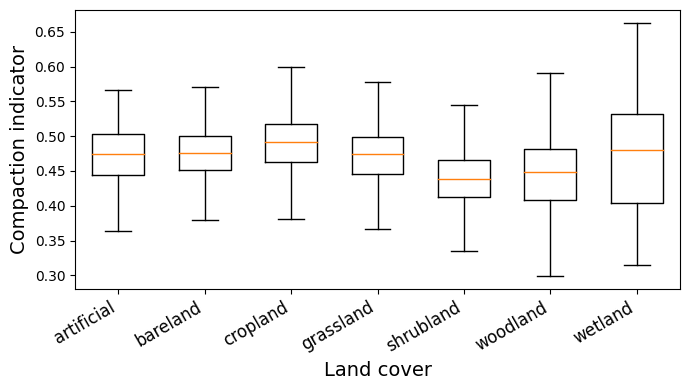

In [64]:

data = [
    hbd.loc[hbd["LC_group"] == lc, "copa"].dropna()
    for lc in lc_order
    if lc in hbd["LC_group"].unique()
]

labels = [
    lc for lc in lc_order
    if lc in hbd["LC_group"].unique()
]

fig, ax = plt.subplots(figsize=(7, 4))

ax.boxplot(
    data,
    labels=labels,
    showfliers=False,  
    widths=0.6
)

ax.set_ylabel("Compaction indicator", fontsize=14)
ax.set_xlabel("Land cover", fontsize=14)

plt.xticks(rotation=30, ha="right", fontsize=12)
plt.tight_layout()
plt.savefig(f"./fig/compaction.pdf", bbox_inches="tight")
plt.show()
